# Linear Gaussian

In [3]:
using Distributions, StatsPlots, Plots, StatsBase, LinearAlgebra
using LaTeXStrings
using SymPy
pyplot()

Plots.PyPlotBackend()

In [4]:
function LinearGaussian(t=100,ϕ=0.95, sx=1.0, sy=1.0)
    X,Y,Vt,Wt    = zeros(t),zeros(t),zeros(t),zeros(t)
    s0   = sx / (1-ϕ^2)
    Xo   = sqrt(s0)*rand(Normal(0,1)) # this represents X0
    for i = 1:t
        Vt[i] = rand(Normal(0,1))
        Wt[i] = rand(Normal(0,1))
        if i == 1
            X[i] = Xo   * ϕ + Vt[i]
            Y[i] = X[i] * ϕ + Wt[i]*sqrt(sy)
        else
            X[i] = X[i-1] * ϕ + Vt[i]*sqrt(sx)
            Y[i] = X[i]   * ϕ + Wt[i]*sqrt(sy)
        end
    end
    return (X,Y,Vt,Wt)
end
T = 100
ϕ = 0.95
sample = LinearGaussian(T,ϕ);

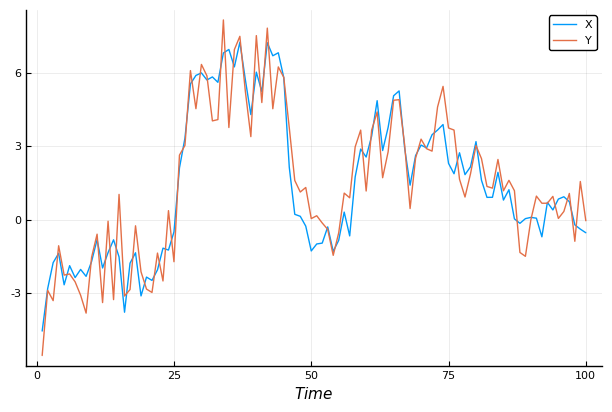

In [7]:
plot(sample[1],label = "X",xlabel=L"Time")
p = plot!(sample[2], label= "Y")
savefig(p, "./images/LinearGaussian.png")

In [9]:
N  = 1000
y  = sample[2]
XB = zeros(N,T)
WB = zeros(N,T)
sx,sy = 1,1
s0 = (sx/(1-ϕ^2))
#sample approximation from p(x1|y1)
XB[:,1] = (rand(Normal(0,1),N).*sqrt(s0))
WB[:,1] = -(y[1].-XB[:,1]).^2/(2*sy^2);

In [10]:
# Boostrap SIS
for t = 2:T
    XB[:,t] = ϕ .* XB[:,t-1] + sqrt(sx) .* rand(Normal(0,1),N)
    WB[:,t] = WB[:,t-1] - (y[t] .- XB[:,t]).^2/(2*sy)
end

In [11]:
N  = 1000
X0 = zeros(N,T)
W0 = zeros(N,T)

so = (1/sx+1/sy)^(-1)
mx(x,y) = (sx*y + sy*x*ϕ)/(sx + sy)
so0 = (1/so + 1/sy)^-1

#sample approximation p(x1|y2)
X0[:,1] = mx(0,y[1]).*ones(N) + so0.*rand(Normal(0,1),N)############ajustar
W0[:,1] = y[1]^2/(sy + s0)*(-1/2).*ones(N);

#sample condicionally approx p(x1:t |y1:t)
for t in 2:T
    X0[:,t] = mx.(X0[:,t-1],y[t]) + so.*rand(Normal(0,1),N)
    W0[:,t] = W0[:,t-1] - (y[t] .- ϕ.*X0[:,t-1]).^2/(2*(sx+sy))
end

In [12]:
function calc_weights(W,t)
    w = W[:,t]
    maxw = maximum(w)
    sw = sum(exp.(w.-maxw))
    return exp.(w .-maxw .- log(sw))
end

calc_weights (generic function with 1 method)

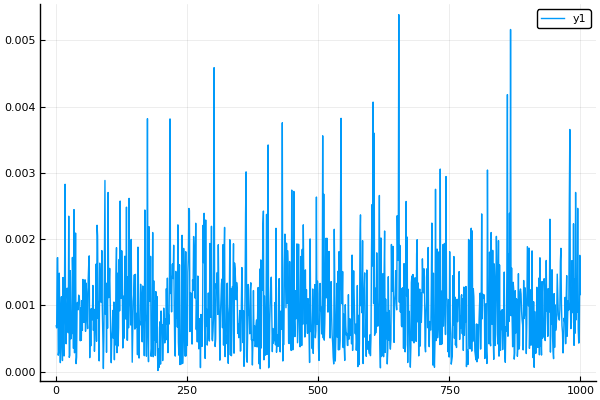

In [17]:
WBnorm = calc_weights(WB,10)
W0norm = calc_weights(W0,10)

plot(W0norm)

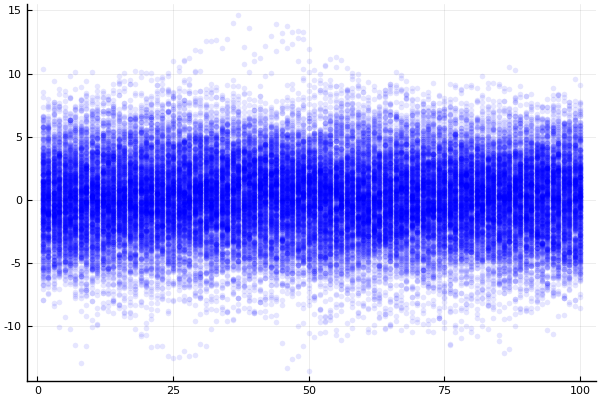

In [43]:
# plot(XB)
scatter(XB'[:,1],c=:blue,legend=false,markerstrokewidth=0,alpha=0.1)
for i = 2:500
    p = scatter!(XB'[:,i],c=:blue,legend=:false,markerstrokewidth=0,alpha=0.1)
end
p